# Fusing NV Segformer 2D semantic into Sparse Voxels

We use the trained `garden` scene from the [example.ipynb](./example.ipynb).

In [1]:
import os
PROJECT_ROOT = os.path.abspath('../')
print("PROJECT_ROOT:", PROJECT_ROOT)

import sys
sys.path.insert(0, PROJECT_ROOT)

import time
import cv2
import numpy as np
from tqdm import tqdm
import imageio
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from IPython.display import Image, Video

import torch

from src.config import cfg, update_argparser, update_config

from src.dataloader.data_pack import DataPack
from src.sparse_voxel_model import SparseVoxelModel
from src.cameras import MiniCam
from src.utils.image_utils import im_tensor2np, viz_tensordepth
from src.utils.activation_utils import shzero2rgb, rgb2shzero
from src.utils.octree_utils import level_2_vox_size
from src.utils.fuser_utils import Fuser
from src.utils.camera_utils import interpolate_poses

import svraster_cuda

PROJECT_ROOT: /home/chengs/voxworld


In [2]:
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, 'output', 'tutorial')
print("OUTPUT_ROOT:", OUTPUT_ROOT)

DATA_ROOT: /home/chengs/voxworld/data/360_v2/garden
OUTPUT_ROOT: /home/chengs/voxworld/output/tutorial


## Load everything

In [3]:
# Load semantic segmentator
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

logit_sharpening = 1.0

# List of models: https://huggingface.co/models?search=nvidia/segformer
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True, device="cuda")
image_mean = torch.tensor(image_processor.image_mean, dtype=torch.float32, device="cuda")
image_std = torch.tensor(image_processor.image_std, dtype=torch.float32, device="cuda")
model = SegformerForSemanticSegmentation.from_pretrained(model_name).cuda()
model.eval()
for param in model.parameters():
    param.requires_grad = False

num_classes = model.decode_head.classifier.out_channels
if num_classes == 150:
    # ADE20K dataset
    pallete = torch.tensor(
        [120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255],
        dtype=torch.float32,
        device="cuda").reshape(-1, 3) / 255
elif num_classes == 19:
    # Cityscape dataset
    pallete = torch.tensor(
        [128, 64,128,244, 35,232, 70, 70, 70,102,102,156,190,153,153,153,153,153,250,170, 30,220,220,  0,107,142, 35,152,251,152, 70,130,180,220, 20, 60,255,  0,  0,  0,  0,142,  0,  0, 70,  0, 60,100,  0, 80,100,  0,  0,230,119, 11, 32],
        dtype=torch.float32,
        device="cuda").reshape(-1, 3) / 255
else:
    raise NotImplementedError


def preprocess_image(x):
    H, W = x.shape[-2:]
    if H > W:
        tH = 640 * H / W
        tW = 640
    else:
        tW = 640 * W / H
        tH = 640
    tH = round(tH / 32) * 32
    tW = round(tW / 32) * 32
    x = torch.nn.functional.interpolate(
        x[None],
        size=(tH, tW),
        mode='bilinear',
        align_corners=False,
    )
    x = (x - image_mean.view(1, 3, 1, 1)) / image_std.view(1, 3, 1, 1)
    return x

def segment_image(x):
    pixel_values = preprocess_image(x)
    probs = model(pixel_values).logits.mul(logit_sharpening).softmax(dim=1).squeeze(0)
    return probs

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


In [4]:
model_path = OUTPUT_ROOT
update_config(os.path.join(model_path, 'config.yaml'))

In [5]:
# Load data
data_pack = DataPack(cfg.data, cfg.model.white_background)
tr_cams = data_pack.get_train_cameras()
te_cams = data_pack.get_test_cameras()

Read dataset in COLMAP format.
images_folder=/home/chengs/voxworld/data/360_v2/garden/images
res_downscale=0.0
res_width=0
[WARN] Source images are too large (5187x3361). 
       Auto downscale gt by 4.077485483823158. 
       Use `--images`, `--res_downscale`, or `--res_width` to prevent it.


In [6]:
# Load model
voxel_model = SparseVoxelModel(cfg.model)
loaded_iter = voxel_model.load_iteration()
ori_sh0 = voxel_model.sh0.data.clone()
ori_shs = voxel_model.shs.data.clone()

## Fusing 2D semantic segmentation

In [7]:
with torch.no_grad():

    # Define volume integrator
    finest_vox_size = level_2_vox_size(voxel_model.scene_extent, voxel_model.octlevel.max()).item()
    feat_volume = Fuser(
        xyz=voxel_model.vox_center,
        bandwidth=50 * finest_vox_size,
        use_trunc=False,
        fuse_tsdf=False,
        feat_dim=num_classes,
        crop_border=0.,
        normal_weight=False,
        depth_weight=False,
        border_weight=False,
        use_half=True)

    # Run semantic maps fusion
    for cam in tqdm(tr_cams):
        probs = segment_image(cam.image.cuda())
        render_pkg = voxel_model.render(cam, output_depth=True)
        depth = render_pkg['depth'][2]
        feat_volume.integrate(cam=cam, feat=probs, depth=depth)


# Get the final feature and cleanup
torch.cuda.empty_cache()
feature = feat_volume.feature.nan_to_num_()

del feat_volume
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:23<00:00,  6.82it/s]


## Visualization

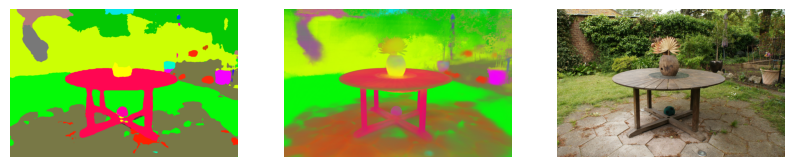

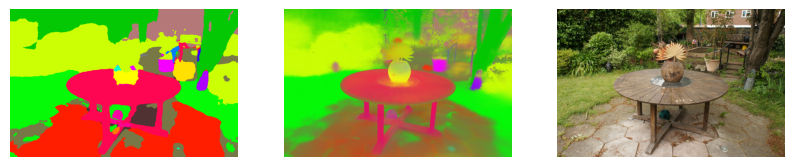

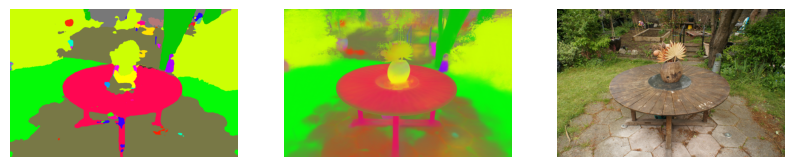

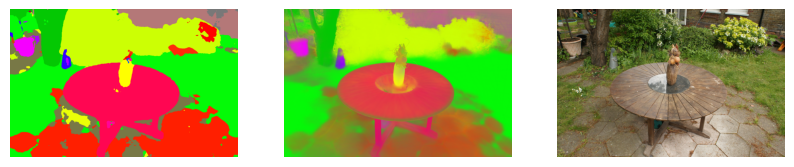

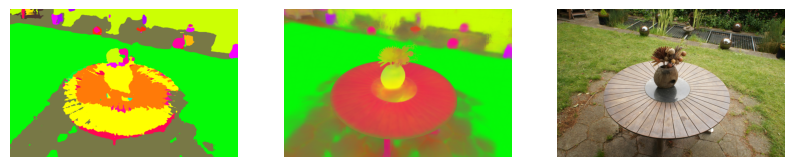

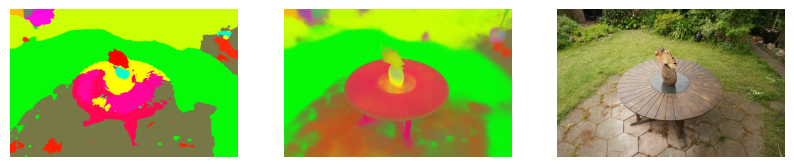

In [8]:
with torch.no_grad():

    voxel_model.sh0.data[:] = rgb2shzero(feature @ pallete.to(feature.dtype)).float()
    voxel_model.shs.data[:] = 0

    for cam in tr_cams[::len(tr_cams)//5]:
        probs = segment_image(cam.image.cuda())
        probs = torch.nn.functional.interpolate(
            probs[None],
            size=cam.image.shape[-2:], mode='bilinear')[0]
        confidence, clsidx = probs.max(0)
        clscolor = pallete[clsidx]

        render_clscolor = voxel_model.render(cam)['color']
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
        ax[0].imshow(clscolor.mul(255).cpu().numpy().astype(np.uint8))
        ax[1].imshow(im_tensor2np(render_clscolor))
        ax[2].imshow(im_tensor2np(cam.image))
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

## Render fly-through video

In [9]:
key_frame_ids = [] # Set to empty list to enable farthest point sampling
periodic = True
n_frames = 300

fovx = tr_cams[0].fovx
fovy = tr_cams[0].fovy
width = round(tr_cams[0].image_width * 1.0)
height = round(tr_cams[0].image_height * 1.0)
near = tr_cams[0].near

In [10]:
# Use farthest point sampling
if len(key_frame_ids) == 0:
    cam_pos = torch.stack([cam.position for cam in tr_cams])
    key_frame_ids = [0]
    for _ in range(3):
        farthest_id = torch.cdist(cam_pos[key_frame_ids], cam_pos).amin(0).argmax().item()
        key_frame_ids.append(farthest_id)
    key_frame_ids[1], key_frame_ids[2] = key_frame_ids[2], key_frame_ids[1]
    key_poses = [tr_cams[i].c2w.cpu().numpy() for i in key_frame_ids]

key_poses = [tr_cams[i].c2w.cpu().numpy() for i in key_frame_ids]
interp_poses = interpolate_poses(key_poses, n_frame=n_frames, periodic=periodic)

interp_cams = [
    MiniCam(
        c2w=pose,
        fovx=fovx, fovy=fovy,
        width=width, height=height,
        near=near)
    for pose in interp_poses
]

In [11]:
outroot = 'demos_segformer'
scene_name = os.path.split(voxel_model.model_path)[1]
os.makedirs(outroot, exist_ok=True)

with torch.no_grad():

    voxel_model.sh0.data[:] = ori_sh0
    voxel_model.shs.data[:] = ori_shs
    video = [
        im_tensor2np(voxel_model.render(cam)['color'])
        for cam in tqdm(interp_cams)
    ]
    imageio.mimwrite(f"{outroot}/{scene_name}_rgb.mp4", video, quality=8, fps=30)

    voxel_model.sh0.data[:] = rgb2shzero(feature @ pallete.to(feature.dtype)).float()
    voxel_model.shs.data[:] = 0
    video = [
        im_tensor2np(voxel_model.render(cam)['color'])
        for cam in tqdm(interp_cams)
    ]
    imageio.mimwrite(f"{outroot}/{scene_name}_A.mp4", video, quality=8, fps=30)

    voxel_model.sh0.data[:] = ori_sh0
    voxel_model.shs.data[:] = ori_shs
    video = []
    for cam in tqdm(interp_cams):
        im = voxel_model.render(cam)['color']
        probs = segment_image(im)
        probs = torch.nn.functional.interpolate(
            probs[None],
            size=im.shape[-2:], mode='bilinear')[0]
        confidence, clsidx = probs.max(0)
        clscolor = pallete[clsidx]
        video.append(clscolor.mul(255).cpu().numpy().astype(np.uint8))
    imageio.mimwrite(f"{outroot}/{scene_name}_B.mp4", video, quality=8, fps=30)

# Composite all videos
v0 = cv2.VideoCapture(f"{outroot}/{scene_name}_rgb.mp4")
v1 = cv2.VideoCapture(f"{outroot}/{scene_name}_A.mp4")
v2 = cv2.VideoCapture(f"{outroot}/{scene_name}_B.mp4")
video = []
for i in range(n_frames):
    ret, f0 = v0.read()
    ret, f1 = v1.read()
    ret, f2 = v2.read()
    im = np.concatenate([f0, f1, f2], axis=1)[..., ::-1]
    video.append(im)

imageio.mimwrite(f"{outroot}/{scene_name}.mp4", video, fps=30)
Video(f"{outroot}/{scene_name}.mp4", width=1024)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 88.58it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1272, 824) to (1280, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x63c2240] Warning: data is not aligned! This can lead to a speed loss
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 82.37it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1272, 824) to (1280, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_si